## Exploring OFF database

Useful anomaly detection project https://www.kaggle.com/allunia/hidden-treasures-in-our-groceries/notebook

## Building graphs over Open Food Fact database

In [4]:
import numpy as np 
from importlib import reload # for reloading modules after a script has been modified
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
sns.set()

# from PIL import Image
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import os
print(os.listdir("data"))


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

from scipy.stats import boxcox

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


['fr.openfoodfacts.org.products.csv', 'world-food-facts.zip', 'en.openfoodfacts.org.products.tsv']


In [2]:
import graph_algos as galg
reload(galg)

<module 'graph_algos' from '/home/lucas/Documents/Projets/openfoodfact-graphs/graph_algos.py'>

In [3]:
original = pd.read_csv("data/en.openfoodfacts.org.products.tsv",
                       delimiter='\t',
                       encoding='utf-8',
                        # nrows = 100000,
                      usecols=['product_name', 'ingredients_text', 'categories','nutrition-score-fr_100g',
                               'carbon-footprint_100g', 'energy_100g', 'fat_100g', 
                               'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g'])
original.head(n=5)

,product_name,categories,ingredients_text,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,carbon-footprint_100g,nutrition-score-fr_100g
0,Farine de blé noir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Banana Chips Sweetened (Whole),NaN,"Bananas, vegetable oil (coconut oil, corn oil ...",2243.0,28.57,64.29,14.29,3.57,0.00000,0.000,NaN,14.0
2,Peanuts,NaN,"Peanuts, wheat flour, sugar, rice flour, tapio...",1941.0,17.86,60.71,17.86,17.86,0.63500,0.250,NaN,0.0
3,Organic Salted Nut Mix,NaN,"Organic hazelnuts, organic cashews, organic wa...",2540.0,57.14,17.86,3.57,17.86,1.22428,0.482,NaN,12.0
4,Organic Polenta,NaN,Organic polenta,1552.0,1.43,77.14,NaN,8.57,NaN,NaN,NaN,NaN


In [13]:
a = (np.array(original['nutrition-score-fr_100g'], dtype=str) != "nan")
print(a.sum())
np.array(original[['product_name','nutrition-score-fr_100g','categories']])[a]
print(np.array(original['nutrition-score-fr_100g'])[a].max())

254856
40.0


In [24]:
original = pd.read_csv("data/en.openfoodfacts.org.products.tsv",
                       delimiter='\t',
                       encoding='utf-8',
                        nrows = 1000)
print(np.array(original.columns))
original.head(5)

['code' 'url' 'creator' 'created_t' 'created_datetime' 'last_modified_t'
 'last_modified_datetime' 'product_name' 'generic_name' 'quantity'
 'packaging' 'packaging_tags' 'brands' 'brands_tags' 'categories'
 'categories_tags' 'categories_en' 'origins' 'origins_tags'
 'manufacturing_places' 'manufacturing_places_tags' 'labels' 'labels_tags'
 'labels_en' 'emb_codes' 'emb_codes_tags' 'first_packaging_code_geo'
 'cities' 'cities_tags' 'purchase_places' 'stores' 'countries'
 'countries_tags' 'countries_en' 'ingredients_text' 'allergens'
 'allergens_en' 'traces' 'traces_tags' 'traces_en' 'serving_size'
 'no_nutriments' 'additives_n' 'additives' 'additives_tags' 'additives_en'
 'ingredients_from_palm_oil_n' 'ingredients_from_palm_oil'
 'ingredients_from_palm_oil_tags'
 'ingredients_that_may_be_from_palm_oil_n'
 'ingredients_that_may_be_from_palm_oil'
 'ingredients_that_may_be_from_palm_oil_tags' 'nutrition_grade_uk'
 'nutrition_grade_fr' 'pnns_groups_1' 'pnns_groups_2' 'states'
 'states_tags' 

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN

In [4]:
original.shape

(356027, 10)

In [5]:
# columns indicated by above warning
column_names = original.columns
column_names[[26,28,37,38,39,48]]

IndexError: index 26 is out of bounds for axis 1 with size 10

In [6]:
# colonnes qui ont un ratio de NaN faible
null_ratio = np.zeros((original.shape[1]))
for ind,column_name in enumerate(column_names):
    null_ratio[ind] = original[column_name].isnull().sum()/original.shape[0]
column_selec = column_names[null_ratio<0.1]
column_selec

Index(['product_name'], dtype='object')

In [7]:
original.columns

Index(['product_name', 'ingredients_text', 'energy_100g', 'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'carbon-footprint_100g'], dtype='object')

### Plot a view over products that contain cacao 

In [4]:
contains_cacao = np.core.defchararray.find(np.array(original['ingredients_text'],dtype=str),'cacao')
contains_cacao = np.where(contains_cacao>-1)[0]
original.iloc[contains_cacao]

,product_name,ingredients_text,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,carbon-footprint_100g
696,Spiketail the Dinosaur,Sucre - _Lait_ en poudre entier - Beurre de ca...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1410,"Get Back To Human, Chocolate Bar, Crunchy Mint","Cacao, organic sugar, cacao , pepper mint oil.",2230.0,43.33,43.33,26.67,6.67,0.00000,0.000000,NaN
9580,"Chukar Cherries, Amaretto Rainiers Cherries, D...","Semisweet chocolate (cacao beans, sugar, choco...",1766.0,22.50,62.50,52.50,2.50,0.05588,0.022000,NaN
9583,Dessert Sauce,"Semisweet chocolate (cacao beans, sugar, choco...",1452.0,17.65,52.94,47.06,0.00,5.79628,2.282000,NaN
9804,Mini Crêpes ChocoLait,"Chocolat au lait 45% (sucre, beurre de cacao, ...",2018.0,18.00,72.00,48.00,6.70,0.20000,0.078740,NaN
11216,"Stirs The Soul, Pure Dark Chocolate Bar","Stone-ground cacao*, cacao butter*, coconut pa...",2540.0,46.43,35.71,17.86,10.71,0.00000,0.000000,NaN
11356,Chocolate Chunk Dark Double Chocolate Crispy C...,"Morceaux de chocolat noir 38% (sucre, pâte de ...",2131.0,25.30,66.50,34.80,3.80,0.80000,0.314961,NaN
13181,Nuts About Energy Balls,"Dates, pumpkin seed protein, cashews, cacao ni...",1393.0,19.05,45.24,26.19,19.05,0.30226,0.119000,NaN
13540,Brins de ChocoCaramel,"Chocolat au lait 40% (sucre, beurre de cacao, ...",1960.0,16.00,75.00,50.00,5.00,0.28000,0.110236,NaN
15988,Extra Dark Chocolate,"Extra dark chocolate (cacao beans, pure cane s...",1941.0,28.57,64.29,50.00,3.57,0.00000,0.000000,NaN


In [5]:
working_df = original.iloc[contains_cacao]
working_df = working_df.fillna(0)
print("nrows =",working_df.shape[0])
print("nrows that look suspiciously wrong =",(working_df[['fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g','sodium_100g']].sum(axis=1) < 10).sum(axis=0))
working_df

nrows = 5538
nrows that look suspiciously wrong = 310


,product_name,ingredients_text,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,carbon-footprint_100g
696,Spiketail the Dinosaur,Sucre - _Lait_ en poudre entier - Beurre de ca...,0.0,0.00,0.00,0.00,0.00,0.00000,0.000000,0.0
1410,"Get Back To Human, Chocolate Bar, Crunchy Mint","Cacao, organic sugar, cacao , pepper mint oil.",2230.0,43.33,43.33,26.67,6.67,0.00000,0.000000,0.0
9580,"Chukar Cherries, Amaretto Rainiers Cherries, D...","Semisweet chocolate (cacao beans, sugar, choco...",1766.0,22.50,62.50,52.50,2.50,0.05588,0.022000,0.0
9583,Dessert Sauce,"Semisweet chocolate (cacao beans, sugar, choco...",1452.0,17.65,52.94,47.06,0.00,5.79628,2.282000,0.0
9804,Mini Crêpes ChocoLait,"Chocolat au lait 45% (sucre, beurre de cacao, ...",2018.0,18.00,72.00,48.00,6.70,0.20000,0.078740,0.0
11216,"Stirs The Soul, Pure Dark Chocolate Bar","Stone-ground cacao*, cacao butter*, coconut pa...",2540.0,46.43,35.71,17.86,10.71,0.00000,0.000000,0.0
11356,Chocolate Chunk Dark Double Chocolate Crispy C...,"Morceaux de chocolat noir 38% (sucre, pâte de ...",2131.0,25.30,66.50,34.80,3.80,0.80000,0.314961,0.0
13181,Nuts About Energy Balls,"Dates, pumpkin seed protein, cashews, cacao ni...",1393.0,19.05,45.24,26.19,19.05,0.30226,0.119000,0.0
13540,Brins de ChocoCaramel,"Chocolat au lait 40% (sucre, beurre de cacao, ...",1960.0,16.00,75.00,50.00,5.00,0.28000,0.110236,0.0
15988,Extra Dark Chocolate,"Extra dark chocolate (cacao beans, pure cane s...",1941.0,28.57,64.29,50.00,3.57,0.00000,0.000000,0.0


In [10]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource

output_file("plot_cacao_products.html")

source = ColumnDataSource(data=working_df)

TOOLTIPS = [
    ("name", "@product_name"),
    ("energy (kJ)", "@energy_100g"),
    ("sugars (g)", "@sugars_100g"),
]

p = figure(plot_width=400, plot_height=400, tooltips=TOOLTIPS,
           title="Cacao products")

p.circle('energy_100g', 'sugars_100g', size=2, source=source)

show(p)

### Build a graph over products that contain cacao

Limits of $\epsilon$-graph:
- how to choose $\epsilon$
- for a connected graph, outliers cause a high $\epsilon$ which limits sparsity

We should use metric learning for this?

In [14]:
import scipy
reload(galg)

<module 'graph_algos' from '/home/lucas/Documents/Projets/openfoodfact-graphs/graph_algos.py'>

In [15]:
working_arr = np.array(working_df)
working_arr_100g = working_arr[:,2:9] # without product_name ingredients carbon_footprint

W = galg.build_similarity(working_arr_100g)
#L = galg.build_laplacian(W)

/home/lucas/Documents/Projets/openfoodfact-graphs/graph_helper.py:83: RuntimeWarning: invalid value encountered in multiply
  A=B*adj
/home/lucas/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [10]:
scipy.sparse.linalg.eigs(L)

(array([1.9895819 +0.j, 1.78750167+0.j, 1.76604974+0.j, 1.76501869+0.j,
        1.76377037+0.j, 1.75867994+0.j]),
 array([[-5.81465762e-02+0.j,  4.42313938e-17+0.j, -5.48564726e-17+0.j,
         -1.23551093e-17+0.j, -5.87189283e-17+0.j, -9.91548248e-17+0.j],
        [-1.45443940e-18+0.j,  3.56079923e-18+0.j,  2.19956976e-14+0.j,
         -1.80033525e-16+0.j, -3.51047703e-16+0.j, -1.29750761e-08+0.j],
        [-3.33187995e-18+0.j,  6.33987564e-11+0.j,  1.33471427e-18+0.j,
          5.44071090e-06+0.j, -2.70122040e-10+0.j,  2.65202033e-17+0.j],
        ...,
        [ 5.13393826e-18+0.j,  5.37697837e-16+0.j,  1.10133025e-06+0.j,
          9.33575058e-15+0.j, -1.39990570e-14+0.j, -3.76522921e-02+0.j],
        [-5.81465762e-02+0.j,  5.31901787e-17+0.j, -7.47521264e-17+0.j,
         -5.05544036e-18+0.j, -6.93773800e-17+0.j, -8.51378372e-17+0.j],
        [ 3.60953139e-18+0.j,  1.12971299e-04+0.j,  3.08362748e-17+0.j,
          1.69843763e-06+0.j,  6.88276871e-16+0.j,  1.30678409e-18+0.j]]))

In [46]:
((L!=0).sum(axis=1)!=0)

2425

In [43]:
L[0,-1]

0.0

[1.30442218+0.j 1.30723317+0.j 1.31034828+0.j 1.31120676+0.j
 1.31153903+0.j 1.31567523+0.j 1.31798035+0.j 1.33683267+0.j
 1.40212715+0.j 1.92999224+0.j]
[3585 3348 3397 3462 2894 3181 2804 2316  442  361] (5538, 10)


/home/lucas/Documents/Projets/openfoodfact-graphs/graph_algos.py:84: RuntimeWarning: invalid value encountered in true_divide
  U_chosen = (U_chosen.T / rows_norm).T
/home/lucas/.local/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


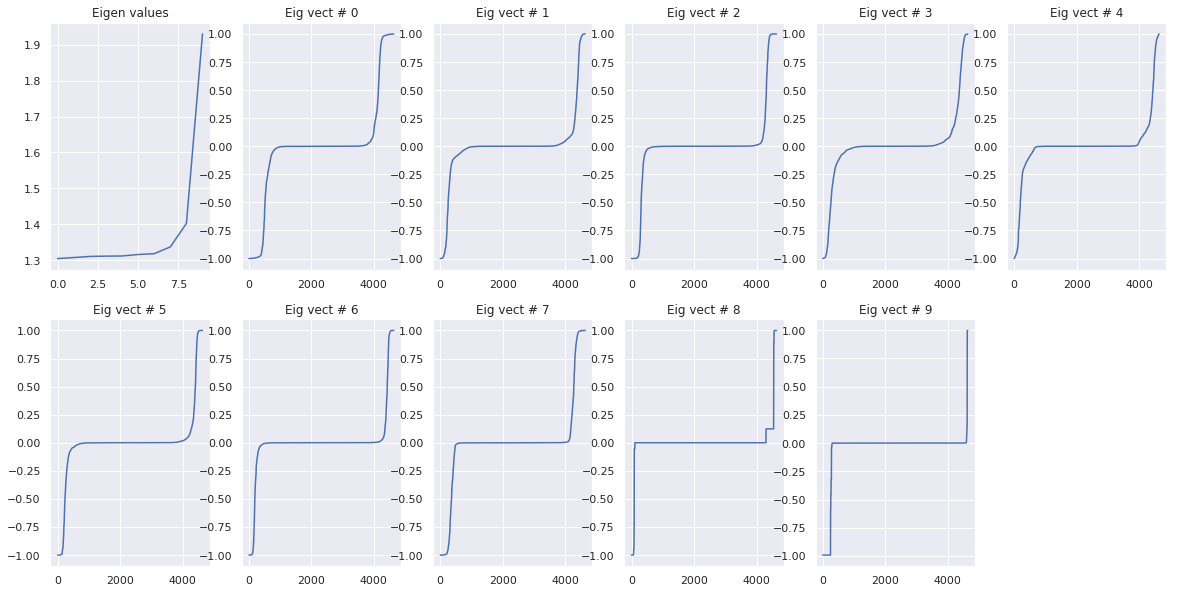

In [10]:
chosen_eig_indices = np.arange(0,10,1)
galg.spectral_analysis(L,chosen_eig_indices,do_clusters=False,do_plots=True,num_classes=None)

In [39]:
np.zeros(8)[[1,2]]

array([0., 0.])

In [23]:
np.array(original['ingredients_text'][1:4])

array(['Bananas, vegetable oil (coconut oil, corn oil and/or palm oil) sugar, natural banana flavor.',
       'Peanuts, wheat flour, sugar, rice flour, tapioca starch, salt, leavening (ammonium bicarbonate, baking soda), soy sauce (water, soybeans, wheat, salt), potato starch.',
       'Organic hazelnuts, organic cashews, organic walnuts almonds, organic sunflower oil, sea salt.'],
      dtype=object)

Columns that might be used are:
- texts: product_name countries serving_size ingredients_text  carbon-footprint_100g
- numeric and non Nan: energy_100g fat_100g carbohydrates_100g sugars_100g proteins_100g salt_100g sodium_100g

TODO:
- if execution is too long, choose hyperparameters with random samples
- 

## Baseline categorization

A baseline from https://gist.github.com/raphael0202/22a6600302d4f343c93ff319273003a9

In [2]:
import re

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

PUNCTUATION_REGEX = re.compile(r"""[:,;.&~"'|`_\\={}%()\[\]]+""")
DIGIT_REGEX = re.compile(r"[0-9]+")
MULTIPLE_SPACES_REGEX = re.compile(r" +")

def preprocess(text):
    text = PUNCTUATION_REGEX.sub(' ', text)
    text = DIGIT_REGEX.sub(' ', text)
    return MULTIPLE_SPACES_REGEX.sub(' ', text)

In [59]:
df = pd.read_csv("data/fr.openfoodfacts.org.products.csv",
                       delimiter='\t',
                       encoding='utf-8',
                         nrows = 300000,
                      usecols=['product_name', 
                               'ingredients_text', 
                             #  'nutrition-score-fr_100g', 'carbon-footprint_100g', 
                             #  'energy_100g', 'fat_100g', 
                             #  'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
                              'categories_tags','countries_tags','categories'
                              ],
                      converters={'categories_tags': lambda x: x.split(',') if x else np.NaN}
                      )
df.head(n=5)

,product_name,categories,categories_tags,countries_tags,ingredients_text
0,Vitória crackers,NaN,NaN,en:france,NaN
1,Cacao,NaN,NaN,en:france,NaN
2,Sauce Sweety chili 0%,NaN,NaN,en:france,NaN
3,Mini coco,NaN,NaN,en:france,NaN
4,Pistou d'ail des ours,NaN,NaN,en:france,NaN


In [60]:
df = df[pd.notnull(df['categories_tags'])]
df = df[pd.notnull(df['ingredients_text'])]

fr_df = df[df['countries_tags'] == 'en:france']

In [61]:
selected_categories = [
    "en:beverages",
    "en:sugary-snacks",
    "en:meals",
    "en:dairies",
    "en:meats",
    "en:desserts",
    "en:frozen-foods",
    "en:breakfasts",
    "en:cheeses",
    "en:biscuits",
    "en:groceries",
    "en:fats",
    "en:chocolates",
    "en:sauces",
]

selected_categories_set = set(selected_categories)

criterion = fr_df['categories_tags'].map(lambda x: bool(set(x).intersection(selected_categories_set)))
cat_df = fr_df[criterion]
cat_df['categories_tags_int'] = fr_df['categories_tags'].map(lambda categories: [selected_categories.index(x) for x in categories if x in selected_categories])
print(f"{len(fr_df)} elements in original dataframe, {len(cat_df)} after category filter")

21140 elements in original dataframe, 15615 after category filter


/home/lucas/miniconda3/envs/basics/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
y = [np.array(c) for c in cat_df['categories_tags_int'].values]
y = MultiLabelBinarizer().fit_transform(y)
X = cat_df.ingredients_text.values

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(strip_accents='unicode', min_df=5, preprocessor=preprocess)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC()))])

classifier.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1),
        preprocessor=<function preprocess a..._class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=None))])

In [12]:
y_pred = classifier.predict(X_test)
y_pred.shape

(11412, 14)

In [13]:
print(classification_report(y_test, y_pred, target_names=selected_categories))

                  precision    recall  f1-score   support

    en:beverages       0.94      0.91      0.93      2527
en:sugary-snacks       0.94      0.91      0.92      2044
        en:meals       0.89      0.87      0.88      1599
      en:dairies       0.94      0.89      0.92      1664
        en:meats       0.96      0.93      0.94      1165
     en:desserts       0.82      0.71      0.76      1090
 en:frozen-foods       0.82      0.59      0.69       725
   en:breakfasts       0.92      0.80      0.86       818
      en:cheeses       0.97      0.93      0.95       716
     en:biscuits       0.88      0.81      0.84       580
    en:groceries       0.89      0.80      0.84       886
         en:fats       0.92      0.72      0.80       448
   en:chocolates       0.89      0.80      0.84       541
       en:sauces       0.89      0.79      0.84       561

       micro avg       0.92      0.85      0.88     15364
       macro avg       0.90      0.82      0.86     15364
    weighted

/home/lucas/miniconda3/envs/basics/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


## TF-IDF over ingredients, metric learning, product recommendation

In [62]:
from metric_learn import LMNN
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD

y = [np.array(c) for c in cat_df['categories_tags_int'].values]
y = MultiLabelBinarizer().fit_transform(y)
y = y.argmax(axis=1)
X = cat_df.ingredients_text.values

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [63]:
metric_learner = Pipeline([
    ('vectorizer', CountVectorizer(strip_accents='unicode', min_df=5, preprocessor=preprocess)),
    ('tfidf', TfidfTransformer()),
    ('pca', TruncatedSVD(16)),
    ('metric', LMNN(k=5,learn_rate=1e-6,verbose=False))
])

In [64]:
metric_learner.fit_transform(X_train,y_train)

/home/lucas/miniconda3/envs/basics/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


MemoryError: 

In [50]:
y_train

array([10,  3,  3, ...,  7, 11,  3])

In [45]:
y_train

array([0, 1, 0, ..., 0, 0, 1])